# Experiments with Adaptive and Reliable Classification

This notebook provides a demonstration of the Adaptive and Reliable Classification (ARC) Python package through numerical experiments with simulated data.

Accompanying paper:
 - "Classification with Valid and Adaptive Coverage", Y. Romano, M. Sesia, E. Candès, 2020.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '..')
import arc
from arc import models
from arc import methods
from arc import black_boxes
from arc import others
from arc import coverage

/home/users/msesia/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
np.random.seed(2020)                                   # Make this notebook reproducible

## Data

We generate data from a toy model with 10 explanatory variables and a qualitative label for each sample, which is designed to mimic "heteroschedasticity" in a classification setting.
More precisely, the first variable controls the "noise level" in the label: small values of $X_0$ mean that all labels are more or less equally likely; large values of $X_0$ mean that one label is much more likely than the others (which one is determined by the other features).
To clarify, we visualize below the distribution of the true label probabilities (for one value of the label) as a function of $X_0$, which here can take only two possible values for simplicity. 

In [3]:
p = 10                                                 # Number of features
K = 10                                                 # Number of possible labels
data_model = models.Model_Ex1(K,p)                     # Data generating model

n = 500                                                # Number of data samples
X = data_model.sample_X(n)                             # Generate the data features
Y = data_model.sample_Y(X)                             # Generate the data labels conditional on the features

n_test = 1000                                          # Number of test samples
X_test = data_model.sample_X(n_test)                   # Generate independent test data
Y_test = data_model.sample_Y(X_test)

## Evaluating prediction sets

We will evaluate prediction sets in terms of marginal coverage, estimated worst-slice conditional coverage, size, and size conditional on coverage.

In [4]:
def evaluate_predictions(S, X, y, conditional=True):
    # Marginal coverage
    marg_coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    if conditional:
        # Estimated conditional coverage (worse-case slab)
        wsc_coverage = coverage.wsc_unbiased(X, y, S, M=100)
    else:
        wsc_coverage = None
    # Size and size conditional on coverage
    size = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    size_cover = np.mean([len(S[i]) for i in idx_cover])
    # Combine results
    out = pd.DataFrame({'Coverage': [marg_coverage], 'Conditional coverage': [wsc_coverage],
                        'Size': [size], 'Size cover': [size_cover]})
    return out

def evaluate_predictions_2(S, X, y, condition_on):
    # Evaluate conditional coverage given a desired set of variables
    cover = np.array([y[i] in S[i] for i in range(len(y))])
    length = np.array([len(S[i]) for i in range(len(y))])
    out = pd.DataFrame({'Cover': cover, 'Length': length})
    for j in condition_on:
        var_name = "X{}".format(j)
        out[var_name] = X[:,j]
    return out

## Numerical experiments

The following code will sample independent train and test data sets and apply to them all requested methods. 

In [5]:
def run_experiment(data_model, n_train, methods, black_boxes, condition_on,
                   alpha=0.1, experiment=0, random_state=2020):
    # Set random seed
    np.random.seed(random_state)

    # Total number of samples
    n_test = 5000
    n = n_train + n_test

    # Generate data
    X = data_model.sample_X(n)
    y = data_model.sample_Y(X)
    # Split data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=random_state)

    results = pd.DataFrame()
    results_full = pd.DataFrame()
    for box_name in black_boxes:
        black_box = black_boxes[box_name]
        for method_name in methods:
            # Train classification method
            method = methods[method_name](X_train, y_train, black_box, alpha, random_state=random_state)
            # Apply classification method
            S = method.predict(X_test)

            # Evaluate results
            res = evaluate_predictions(S, X_test, y_test)
            # Add information about this experiment
            res['Method'] = method_name
            res['Black box'] = box_name
            res['Experiment'] = experiment
            res['Nominal'] = 1-alpha
            res['n_train'] = n_train
            res['n_test'] = n_test

            # Evaluate results (conditional)
            res_full = evaluate_predictions_2(S, X_test, y_test, condition_on)
            # Add information about this experiment
            res_full['Method'] = method_name
            res_full['Black box'] = box_name
            res_full['Experiment'] = experiment
            res_full['Nominal'] = 1-alpha
            res_full['n_train'] = n_train
            res_full['n_test'] = n_test

            # Add results to the list
            results = results.append(res)
            results_full = results_full.append(res_full)

    return results, results_full

We will compare the following calibration methods.

In [6]:
# Comment/uncomment methods to be compared
methods = {
           'SC': arc.methods.SplitConformal, 
           'CV+': arc.methods.CVPlus, 
#           'JK+': arc.methods.JackknifePlus,
           'HCC': arc.others.SplitConformalHomogeneous,
           'CQC': arc.others.CQC
          }

Define the data model.

In [7]:
K = 10
p = 10
mod_xy = arc.models.Model_Ex1(K,p)

We will compare the performance of each calibration method in combination with the following black-box classifiers. 

In [8]:
# Comment/uncomment black-boxes to be compared
black_boxes = {
               'Oracle': arc.black_boxes.Oracle(mod_xy),
               'SVC': arc.black_boxes.SVC(clip_proba_factor = 1e-5, random_state=2020),
#              'RFC': arc.black_boxes.RFC(clip_proba_factor = 1e-5, 
#                                         n_estimators=1000, max_depth=5, max_features=None,
#                                         random_state=2020)
}

Now we will run independent experiments with this setup, aiming to produce prediction sets with $1-\alpha$ coverage.

In [9]:
alpha = 0.1                         # 1-desired marginal coverage level
n = 1000                            # Number of training samples per experiment
n_experiments = 10                  # Number of independent experiments

condition_on = [0]                  # Variables to condition coverage on
    
# Run experiments
results = pd.DataFrame()
results_full = pd.DataFrame()
for experiment in tqdm(range(n_experiments)):
    
    # Random state for this experiment
    random_state = 2020 + experiment

    res, res_full = run_experiment(mod_xy, n, methods, black_boxes, condition_on, 
                                   alpha=alpha, experiment=experiment, random_state=random_state)
    results = results.append(res)
    results_full = results_full.append(res_full)

100%|█████████████████████████████████████████████████████████████████████████████| 10/10 [17:48<00:00, 103.43s/it]


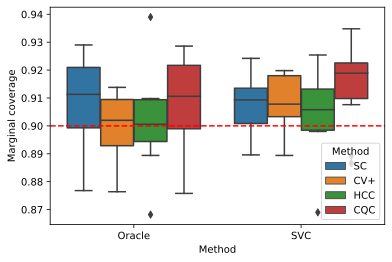

In [10]:
ax = sns.boxplot(y="Coverage", x="Black box", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Marginal coverage')
ax.axhline(1-alpha, ls='--', color="red")
plt.show()

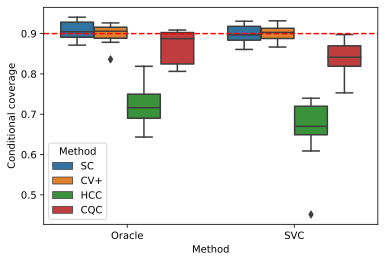

In [11]:
ax = sns.boxplot(y="Conditional coverage", x="Black box", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Conditional coverage')
ax.axhline(1-alpha, ls='--', color="red")
plt.show()

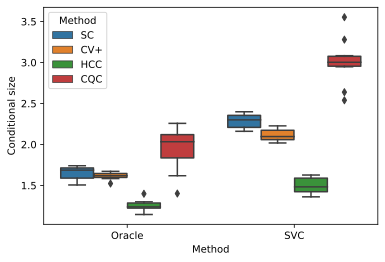

In [12]:
ax = sns.boxplot(y="Size cover", x="Black box", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Conditional size')
plt.show()